# Exploring Transactions Data

Source: [IBM Synthetic Credit Card Transactions Dataset on Kaggle](https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions)

In [1]:
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: f"{x:.2f}")

In [2]:
# Only slim numeric fields down to 32-bit in attempt to prevent overflow issues later
tdf = joblib.load('data/transactions')
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24386900 entries, 1876265 to 363748
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   User            int32         
 1   Card            int32         
 2   Amount          float32       
 3   Use_Chip        object        
 4   Merchant_Name   int32         
 5   Merchant_City   object        
 6   Merchant_State  object        
 7   Zip             float32       
 8   MCC             int32         
 9   Errors          object        
 10  Is_Fraud        bool          
 11  Datetime        datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float32(2), int32(4), object(4)
memory usage: 1.7+ GB


In [33]:
tdf.select_dtypes(include=[np.number]).columns

Index(['User', 'Card', 'Amount', 'Merchant_Name', 'Zip', 'MCC'], dtype='object')

In [38]:
np.iinfo(np.uint8).max

255

## Pre-Process

In [2]:
COL_NAMES = ['User','Card','Year','Month','Day','Time','Amount','Use_Chip',
                 'Merchant_Name','Merchant_City','Merchant_State','Zip','MCC','Errors','Is_Fraud']
PARSE_DATES = ['Year', 'Month', 'Day', 'Time']

In [3]:
temp_df = pd.read_csv('data/split/part00.csv', header=None, names=COL_NAMES)

In [4]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2439999 entries, 0 to 2439998
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use_Chip        object 
 8   Merchant_Name   int64  
 9   Merchant_City   object 
 10  Merchant_State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors          object 
 14  Is_Fraud        object 
dtypes: float64(1), int64(7), object(7)
memory usage: 279.2+ MB


In [14]:
def get_slimmed_numerics(df: pd.DataFrame, basic: bool) -> pd.DataFrame:
    """Adapted from Konrad Banachewicz reduce_mem_usage"""
    if basic:
        df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
        df = df.astype({col: 'float32' for col in df.select_dtypes('float64').columns})
    else:
        for col in df.select_dtypes(include=[np.number]).columns:
            col_type = df[col].dtype
            col_min = df[col].min()
            col_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if col_min >= np.iinfo(np.int8).min and col_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min >= np.iinfo(np.int64).min and col_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if col_min >= np.finfo(np.float16).min and col_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif col_min >= np.finfo(np.float64).min and col_max <= np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    return df

In [16]:
np.finfo(np.float16).min

-65500.0

In [17]:
temp_df = get_slimmed_numerics(df=temp_df, basic=False)
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2439999 entries, 0 to 2439998
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int16  
 1   Card            int8   
 2   Year            int16  
 3   Month           int8   
 4   Day             int8   
 5   Time            object 
 6   Amount          object 
 7   Use_Chip        object 
 8   Merchant_Name   int64  
 9   Merchant_City   object 
 10  Merchant_State  object 
 11  Zip             float32
 12  MCC             int16  
 13  Errors          object 
 14  Is_Fraud        object 
dtypes: float32(1), int16(3), int64(1), int8(3), object(7)
memory usage: 179.2+ MB


In [9]:
from src import process_data

In [10]:
process_data.combine_date_cols(columns=PARSE_DATES, result_col='Datetime', df=temp_df)
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475063 entries, 0 to 2475062
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   User            int64         
 1   Card            int64         
 2   Amount          object        
 3   Use_Chip        object        
 4   Merchant_Name   float64       
 5   Merchant_City   object        
 6   Merchant_State  object        
 7   Zip             float64       
 8   MCC             float64       
 9   Errors          object        
 10  Is_Fraud        object        
 11  Datetime        datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 226.6+ MB


In [19]:
temp_df.Amount.describe()

count     2475062
unique      44915
top        $80.00
freq        19255
Name: Amount, dtype: object

In [11]:
temp_df.sample(n=3)

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
89439,4,0,$42.90,Swipe Transaction,112925206871091072.00,San Francisco,CA,94117.00,5541.00,NaN,No,2009-05-20 06:52:00
133587,6,0,$24.48,Swipe Transaction,-5475680618560174080.00,Georgetown,KY,40324.00,5942.00,NaN,No,2013-08-11 06:20:00
1010178,75,1,$2.40,Swipe Transaction,-5475680618560174080.00,Fayette,AL,35555.00,5942.00,NaN,No,2008-06-15 14:19:00


In [20]:
def get_numeric_amount(df: pd.DataFrame) -> None:
    df['Amount'] = df['Amount'].apply(lambda value: float(str(value)[1:]))
    df['Amount'] = df['Amount'].astype('float32')

In [25]:
# If using -n instead -l (number of files, instead of by lines in each file) to split a file, this can create splits into partial lines
# ONLY USE -l --> updated data/split_transactions.sh to fix
temp_df.loc[temp_df['Amount'].isna()]

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
2475062,205,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [21]:
# To make process_data script more robust for other datasets (this one doesn't have NaN in Amounts) make sure to drop NaN as appropriate
get_numeric_amount(df=temp_df)
temp_df.info()

ValueError: could not convert string to float: 'an'

In [5]:

tdf = process_data.save_space(tdf)

In [6]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2439999 entries, 0 to 2439998
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   User            int32         
 1   Card            int32         
 2   Amount          float32       
 3   Use_Chip        object        
 4   Merchant_Name   int32         
 5   Merchant_City   object        
 6   Merchant_State  object        
 7   Zip             float32       
 8   MCC             int32         
 9   Errors          object        
 10  Is_Fraud        object        
 11  Datetime        datetime64[ns]
dtypes: datetime64[ns](1), float32(2), int32(4), object(5)
memory usage: 167.5+ MB


In [7]:
tdf.head(3)

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
0,0,0,134.09,Swipe,1719741273,La Verne,CA,91750.00,5300,NaN,No,2002-09-01 06:21:00
1,0,0,38.48,Swipe,1102623989,Monterey Park,CA,91754.00,5411,NaN,No,2002-09-01 06:42:00
2,0,0,120.34,Swipe,1102623989,Monterey Park,CA,91754.00,5411,NaN,No,2002-09-02 06:22:00


In [8]:
# tdf['User'] = tdf['User'].astype(np.int8) # There are 2000 simulated customers, so reverted these back to int32
tdf['Card'] = tdf['Card'].astype(np.int8)
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2439999 entries, 0 to 2439998
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   User            int8          
 1   Card            int8          
 2   Amount          float32       
 3   Use_Chip        object        
 4   Merchant_Name   int32         
 5   Merchant_City   object        
 6   Merchant_State  object        
 7   Zip             float32       
 8   MCC             int32         
 9   Errors          object        
 10  Is_Fraud        object        
 11  Datetime        datetime64[ns]
dtypes: datetime64[ns](1), float32(2), int32(2), int8(2), object(5)
memory usage: 153.6+ MB


In [10]:
tdf['Amount'] = tdf['Amount'].apply(lambda value: float(value[1:]))
tdf['Amount'] = tdf['Amount'].astype('float32')
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int32  
 1   Card            int32  
 2   Year            int32  
 3   Month           int32  
 4   Day             int32  
 5   Time            object 
 6   Amount          float32
 7   Use Chip        object 
 8   Merchant City   object 
 9   Merchant State  object 
 10  Zip             float32
 11  MCC             int32  
 12  Errors?         object 
 13  Is Fraud?       object 
dtypes: float32(2), int32(6), object(6)
memory usage: 1.8+ GB


In [11]:
tdf['Use Chip'].value_counts()

Use Chip
Swipe Transaction     15386082
Chip Transaction       6287598
Online Transaction     2713220
Name: count, dtype: int64

In [11]:
tdf['Use Chip'] = tdf['Use Chip'].apply(lambda word: word.split()[0])
tdf['Use Chip'].value_counts()

Use Chip
Swipe     15386082
Chip       6287598
Online     2713220
Name: count, dtype: int64

In [13]:
tdf.info()
joblib.dump(tdf, 'data/slimmed_before_datetime_combine')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int32  
 1   Card            int32  
 2   Year            int32  
 3   Month           int32  
 4   Day             int32  
 5   Time            object 
 6   Amount          float32
 7   Use Chip        object 
 8   Merchant City   object 
 9   Merchant State  object 
 10  Zip             float32
 11  MCC             int32  
 12  Errors?         object 
 13  Is Fraud?       object 
dtypes: float32(2), int32(6), object(6)
memory usage: 1.8+ GB


['data/slimmed_before_datetime_combine']

In [4]:
tdf['Is_Fraud'].value_counts()

Is_Fraud
No     24357143
Yes       29757
Name: count, dtype: int64

In [4]:
tdf['Is_Fraud'] = tdf['Is_Fraud'].apply(lambda word: True if word.lower() == 'yes' else False)
tdf.sample(n=3)

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
516681,462,3,1.65,Swipe,-1952011645,Derby,KS,67037.00,5812,NaN,False,2014-01-19 07:59:00
609455,675,0,13.54,Chip,479254457,Shepherdsville,KY,40165.00,5310,NaN,False,2019-02-20 16:44:00
1843840,1745,0,36.33,Online,-2021769076,ONLINE,NaN,NaN,4784,NaN,False,2013-12-04 14:41:00


### Combine partial dataframes

In [10]:
import os

In [11]:
dir = 'data/slim'
parts = [f for f in os.listdir(dir)]
dfs = []
for part in parts:
    dfs.append(joblib.load(os.path.join(dir, part)))
tdf = pd.concat(dfs)
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24386900 entries, 0 to 2439999
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   User            int8          
 1   Card            int8          
 2   Amount          float32       
 3   Use_Chip        object        
 4   Merchant_Name   int32         
 5   Merchant_City   object        
 6   Merchant_State  object        
 7   Zip             float32       
 8   MCC             int32         
 9   Errors          object        
 10  Is_Fraud        object        
 11  Datetime        datetime64[ns]
dtypes: datetime64[ns](1), float32(2), int32(2), int8(2), object(5)
memory usage: 1.7+ GB


In [12]:
joblib.dump(tdf, 'data/transactions')

['data/transactions']

# Visuals

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
tdf.describe()

,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,24386900.00,24386900.00,24386900.00,24386900.00,21508765.00,24386900.00,24386900
mean,1001.02,1.35,43.63,-5431366.16,50956.41,5561.17,2012-06-15 16:57:04.016494592
min,0.00,0.00,-500.00,-2147477762.00,501.00,1711.00,1991-01-02 07:10:00
25%,510.00,0.00,9.20,-1109575129.00,28374.00,5300.00,2008-12-25 11:34:00
50%,1006.00,1.00,30.14,11876726.00,46742.00,5499.00,2013-01-11 08:49:00
75%,1477.00,2.00,65.06,1063776993.00,77564.00,5812.00,2016-08-27 19:46:00
max,1999.00,8.00,12390.50,2147427927.00,99928.00,9402.00,2020-02-28 23:58:00
std,569.46,1.41,78.71,1311018995.45,29141.96,879.32,NaN


In [3]:
fdf = tdf.loc[tdf['Is_Fraud']].copy()

In [4]:
df = tdf.loc[~tdf['Is_Fraud']].copy()

In [10]:
fdf.describe()

,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,29757.00,29757.00,29757.00,29757.00,4905.00,29757.00,29757
mean,1011.04,1.62,108.59,35311146.87,52427.47,5252.21,2012-06-22 08:57:49.500957952
min,0.00,0.00,-500.00,-2144772375.00,1057.00,3000.00,1996-07-05 11:11:00
25%,545.00,0.00,18.36,-1002789084.00,32503.00,4829.00,2008-09-29 16:26:00
50%,1020.00,1.00,71.02,38861438.00,44824.00,5311.00,2012-08-03 13:10:00
75%,1487.00,3.00,150.13,1102623989.00,78374.00,5719.00,2016-03-24 14:08:00
max,1997.00,8.00,5694.44,2145070271.00,99504.00,9402.00,2019-10-27 14:54:00
std,559.30,1.52,201.17,1269481372.82,28360.63,989.61,NaN


In [12]:
df.describe()

,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,24357143.00,24357143.00,24357143.00,24357143.00,21503860.00,24357143.00,24357143
mean,1001.01,1.35,43.55,-5481141.09,50956.11,5561.55,2012-06-15 16:45:20.264605184
min,0.00,0.00,-500.00,-2147477762.00,501.00,1711.00,1991-01-02 07:10:00
25%,510.00,0.00,9.20,-1109575129.00,28374.00,5300.00,2008-12-25 16:25:00
50%,1006.00,1.00,30.11,11876726.00,46742.00,5499.00,2013-01-11 09:07:00
75%,1477.00,2.00,65.00,1063776993.00,77564.00,5812.00,2016-08-28 08:02:00
max,1999.00,8.00,12390.50,2147427927.00,99928.00,9402.00,2020-02-28 23:58:00
std,569.47,1.41,78.43,1311068187.80,29142.59,879.11,NaN


In [15]:
fdf['MCC'].value_counts().head(10)

MCC
5311    4824
5300    2201
5310    2152
4829    1607
5912    1057
5411     943
5815     879
5651     849
5732     843
5719     717
Name: count, dtype: int64

In [16]:
df['MCC'].value_counts().head(10)

MCC
5411    2859795
5499    2680349
5541    2638628
5812    1797593
5912    1406579
4829    1127454
4784    1124291
5300    1120836
4121     980965
7538     914579
Name: count, dtype: int64

In [17]:
del tdf

In [18]:
joblib.dump(fdf, 'data/fraud_only')

['data/fraud_only']

In [19]:
joblib.dump(df, 'data/no_fraud')

['data/no_fraud']

In [16]:
sns.set(rc={'figure.figsize': (2, 8)})

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


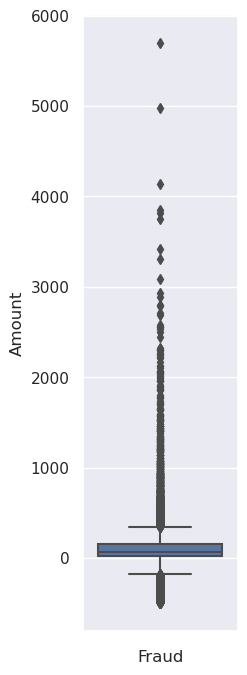

In [17]:
sns.boxplot(y=fdf['Amount'])
plt.xlabel('Fraud')
plt.show()

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


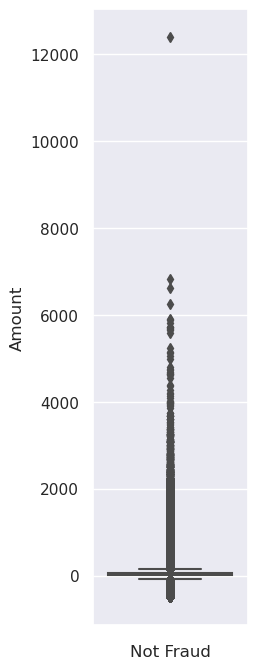

In [18]:
sns.boxplot(y=df['Amount'])
plt.xlabel('Not Fraud')
plt.show()

In [24]:
sns.set(rc={'figure.figsize': (8, 5)})

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


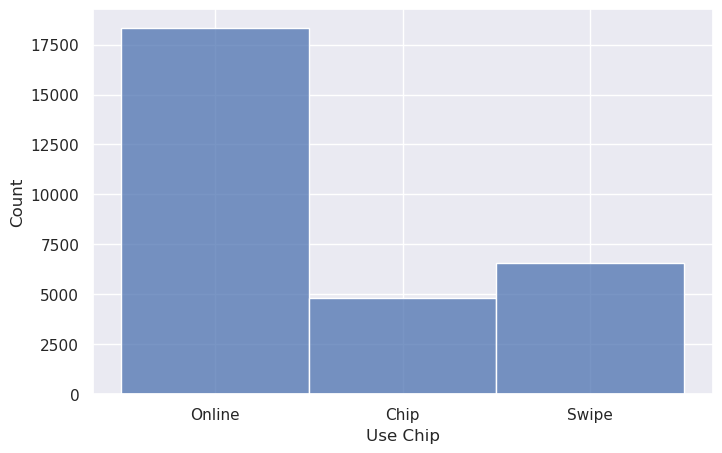

In [25]:
sns.histplot(data=fdf['Use Chip'])
plt.show()

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


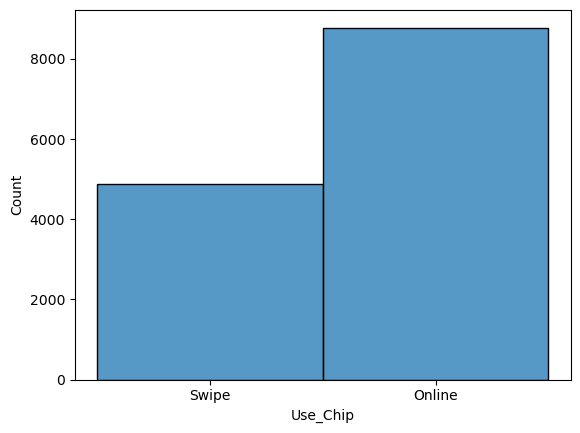

In [7]:
sns.histplot(data=fdf.loc[fdf['Datetime'] < "2012-01-01"]['Use_Chip'])
plt.show()

In [29]:
fdf.loc[(fdf['Datetime'] >= "2016-01-01") & (fdf['Datetime'] < "2018-01-01")]['Use_Chip'].value_counts()

Use_Chip
Online    3073
Chip       527
Swipe      234
Name: count, dtype: int64

In [28]:
len(df.loc[df['Datetime'] >= '2018-01-01'])

3777475

In [31]:
validation_ct = len(fdf.loc[(fdf['Datetime'] >= "2016-01-01") & (fdf['Datetime'] < "2018-01-01")])

In [33]:
for value in [3073, 527, 234]:
    print(value / validation_ct * 100)

80.15127803860199
13.74543557642149
6.103286384976526


In [14]:
len(fdf.loc[fdf.Datetime >= "2015-01-01"]) / len(fdf) * 100

39.294955808717276

In [38]:
len(df.loc[df.Datetime >= "2015-01-01"]) / len(df) * 100

36.55607309937787

In [36]:
nonfraud_train_ct = len(df.loc[(df['Datetime'] >= '2015-01-01') & (df['Datetime'] < '2016-01-01')])

In [35]:
df.loc[(df['Datetime'] >= '2015-01-01') & (df['Datetime'] < '2016-01-01')]['Use_Chip'].value_counts()

Use_Chip
Chip      1197222
Swipe      291795
Online     209073
Name: count, dtype: int64

In [37]:
for v in [1197222, 291795, 209073]:
    print(v / nonfraud_train_ct * 100)

70.50403688850415
17.183718177481758
12.312244934014098


/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


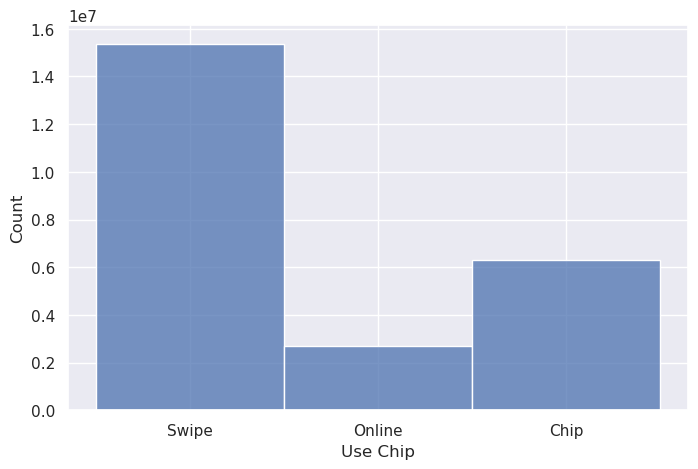

In [26]:
sns.histplot(data=df['Use Chip'])
plt.show()

In [21]:
fdf.head(2)

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
451317,1236,1,171.74,Swipe,440050626,Jacksonville,FL,32218.00,5732,NaN,True,1996-07-05 11:11:00
451318,1236,1,119.30,Swipe,2081821369,Titusville,FL,32796.00,5816,NaN,True,1996-07-05 12:53:00


/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


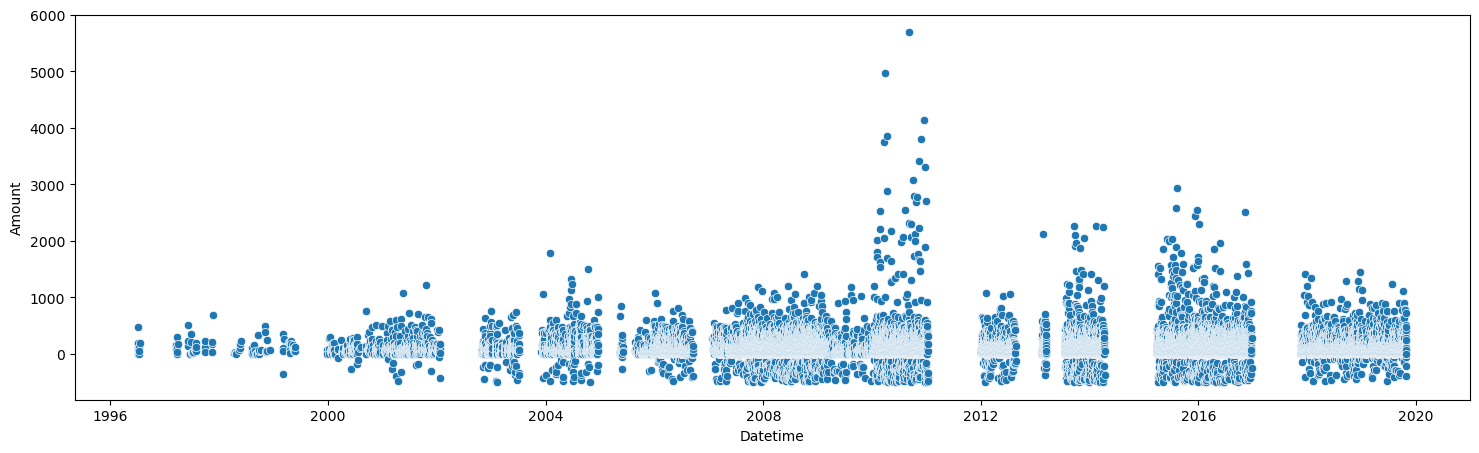

In [26]:
plt.figure(figsize=(18,5))
sns.scatterplot(x=fdf['Datetime'], y=fdf['Amount'])
plt.show()

In [27]:
fdf.loc[(fdf['Datetime'] >= '2011-01-01') & (fdf['Datetime'] < '2012-01-01')].describe()

,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,55.00,55.00,55.00,55.00,0.00,55.00,55
mean,804.73,0.93,113.00,-10509528.78,NaN,4993.95,2011-01-04 12:45:04.363636480
min,148.00,0.00,-490.00,-2113554858.00,NaN,3008.00,2011-01-01 04:23:00
25%,473.00,0.00,43.66,-997347869.50,NaN,4421.50,2011-01-03 10:04:00
50%,848.00,1.00,99.89,38861438.00,NaN,5300.00,2011-01-04 06:03:00
75%,1122.00,2.00,232.20,907190995.00,NaN,5719.00,2011-01-04 13:15:30
max,1739.00,2.00,920.47,2080935213.00,NaN,7011.00,2011-01-12 09:37:00
std,528.65,0.92,258.05,1172076135.68,NaN,928.38,NaN


/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


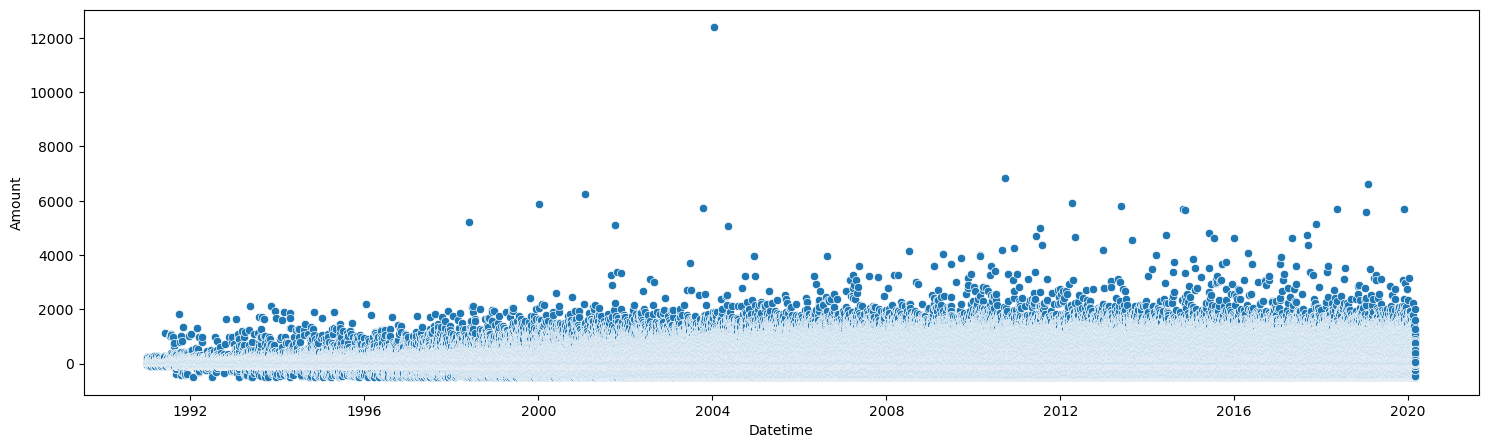

In [28]:
plt.figure(figsize=(18,5))
sns.scatterplot(x=df['Datetime'], y=df['Amount'])
plt.show()

# Train / Validation / Test Splits

In [47]:
# Does the 1:818 ratio still hold when considering only 2015-2020 synthetic data?
START = '2015-01-01'
len(df.loc[df['Datetime'] >= START]) / len(fdf.loc[fdf['Datetime'] >= START])

761.4825109039597

Note: Slimming down the dtypes as much as possible wreaks a bit of havoc on mean and standard deviation - but at least there are the quartiles to compare.

In [39]:
train_nf_pool = df.loc[(df['Datetime'] >= '2015-01-01') & (df['Datetime'] < '2016-01-01')].copy()
print(train_nf_pool.shape)
train_nf_pool.describe()

(1698090, 12)


/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/home/yichenzhang/anacond

,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,1698090.00,1698090.00,1698090.00,1698090.00,1476422.00,1698090.00,1698090
mean,1002.41,1.30,NaN,-477428929105773248.00,51145.17,5558.47,2015-07-02 23:16:24.626998272
min,0.00,0.00,-500.00,-9222899435637403648.00,1001.00,1711.00,2015-01-01 00:01:00
25%,515.00,0.00,9.10,-4530600671233798656.00,28345.00,5300.00,2015-04-02 17:18:00
50%,1006.00,1.00,29.19,-794809796539996544.00,47348.00,5499.00,2015-07-03 06:59:30
75%,1477.00,2.00,63.00,3236310874174399488.00,77573.00,5812.00,2015-10-02 07:48:00
max,1998.00,8.00,4804.00,9222877122873252864.00,99840.00,9402.00,2015-12-31 23:59:00
std,569.96,1.37,NaN,4769953330456576000.00,29361.28,879.74,NaN


In [74]:
portion = 5000 / len(train_nf_pool)
portion

0.0029444846857351495

In [75]:
# Sample 5000 non-fraud training data points, stratifying by Use_Chip
train_nf_sample = train_nf_pool.groupby('Use_Chip', group_keys=False).apply(lambda data: data.sample(frac=0.003))
train_nf_sample.describe()

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,5094.00,5094.00,5094.00,5094.00,4430.00,5094.00,5094
mean,987.01,1.29,inf,-380092999881963456.00,51161.54,5562.96,2015-06-30 00:44:36.077738496
min,0.00,0.00,-485.00,-9204246302766843904.00,1028.00,3001.00,2015-01-01 07:20:00
25%,507.00,0.00,9.60,-4500542936415012352.00,28379.00,5300.00,2015-03-31 00:39:00
50%,983.00,1.00,28.98,-750167460131886592.00,47525.50,5499.00,2015-06-28 13:43:30
75%,1457.75,2.00,61.87,3639123430068731392.00,78130.00,5812.00,2015-09-29 05:10:00
max,1998.00,7.00,1034.00,9222877122873252864.00,99737.00,9402.00,2015-12-31 22:41:00
std,567.11,1.36,inf,4786725718605732864.00,29559.97,893.17,NaN


In [76]:
train_nf_sample['Use_Chip'].value_counts()

Use_Chip
Chip      3592
Swipe      875
Online     627
Name: count, dtype: int64

Use all the fraud transactions from 2015 in training

In [40]:
train_f_pool = fdf.loc[(fdf['Datetime'] >= '2015-01-01') & (fdf['Datetime'] < '2016-01-01')].copy()
print(train_f_pool.shape)
train_f_pool.describe()

(3281, 12)


/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,3281.00,3281.00,3281.00,3281.00,504.00,3281.00,3281
mean,1025.10,1.59,inf,-163518171559036128.00,52739.62,5267.89,2015-08-28 18:09:17.299603968
min,0.00,0.00,-500.00,-9177770777448816640.00,1057.00,3000.00,2015-03-30 09:54:00
25%,466.00,0.00,32.31,-4282466774399734272.00,29702.00,4829.00,2015-06-21 11:25:00
50%,1040.00,1.00,88.00,-521141999023077632.00,48199.00,5310.00,2015-08-26 13:17:00
75%,1571.00,3.00,166.50,4241336128694185472.00,78374.00,5732.00,2015-11-18 10:31:00
max,1995.00,8.00,2930.00,9204012136958900224.00,98660.00,9402.00,2015-12-31 10:41:00
std,592.37,1.51,inf,4861997901622839296.00,28973.06,1041.38,NaN


In [77]:
training_set = pd.concat([train_nf_sample, train_f_pool])
training_set.describe()

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,8375.00,8375.00,8375.00,8375.00,4934.00,8375.00,8375
mean,1001.93,1.41,inf,-295247386541363584.00,51322.73,5447.36,2015-07-23 10:17:54.010746112
min,0.00,0.00,-500.00,-9204246302766843904.00,1028.00,3000.00,2015-01-01 07:20:00
25%,494.00,0.00,12.71,-4282466774399734272.00,28610.00,4900.00,2015-05-01 19:55:30
50%,1002.00,1.00,43.88,-543251973251703872.00,47675.00,5411.00,2015-07-26 16:09:00
75%,1499.00,2.00,99.03,3952145593743244288.00,78148.00,5812.00,2015-10-20 13:17:30
max,1998.00,8.00,2930.00,9222877122873252864.00,99737.00,9402.00,2015-12-31 22:41:00
std,577.40,1.43,inf,4817225411842575360.00,29501.53,964.73,NaN


In [84]:
training_set.sort_values(by=['Datetime', 'User', 'Card'], inplace=True)
joblib.dump(training_set, 'data/train_set_01')

['data/train_set_01']

In [93]:
training_set.head()

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
1826192,787,3,3.81,Chip,6882551472640459815,Trumann,AR,72472.00,5812,NaN,False,2015-01-01 07:20:00
399976,1036,1,47.84,Swipe,-8384568426755457557,Woodmere,NY,11598.00,4121,NaN,False,2015-01-01 08:10:00
2214970,1980,1,7.03,Swipe,1139640404793641563,Charlevoix,MI,49720.00,5541,NaN,False,2015-01-01 10:51:00
130398,215,0,25.38,Swipe,-5739178708996532803,Whitehouse Station,NJ,8889.00,5411,NaN,False,2015-01-01 11:20:00
626119,1848,0,37.75,Chip,-6401694578414405170,New York,NY,10002.00,7995,NaN,False,2015-01-01 12:33:00


In [43]:
validation_nf_pool = df.loc[(df['Datetime'] >= '2016-01-01') & (df['Datetime'] < '2018-01-01')].copy()
print(validation_nf_pool.shape)
validation_nf_pool[['Amount']].describe()

(3428450, 12)


/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/home/yichenzhang/anacond

,Amount
count,3428450.00
mean,NaN
std,NaN
min,-500.00
25%,9.03
50%,29.23
75%,63.00
max,5156.00


In [80]:
print(3000 / len(validation_nf_pool))
print(2000 / len(validation_f_pool))

0.00087503099068092
0.5216484089723527


In [81]:
validation_nf_sample = validation_nf_pool.groupby('Use_Chip', group_keys=False).apply(lambda data: data.sample(frac=0.0009))
validation_nf_sample.describe()

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,3086.00,3086.00,3086.00,3086.00,2683.00,3086.00,3086
mean,1011.44,1.28,inf,-564345283007942144.00,50928.01,5564.79,2016-12-30 10:11:02.877511424
min,0.00,0.00,-483.00,-9207683994561949696.00,1010.00,1711.00,2016-01-01 07:20:00
25%,504.50,0.00,8.79,-4657587665076895744.00,28211.50,5300.00,2016-07-03 01:22:45
50%,1013.50,1.00,28.60,-1053403620709760640.00,46809.00,5499.00,2017-01-05 16:35:30
75%,1519.50,2.00,64.61,3135193399479138304.00,77082.00,5813.00,2017-06-28 18:22:30
max,1997.00,7.00,1547.00,9222877122873252864.00,99508.00,9402.00,2017-12-31 18:04:00
std,578.30,1.37,inf,4765630781641847808.00,29521.08,881.99,NaN


In [44]:
validation_f_pool = fdf.loc[(fdf['Datetime'] >= '2016-01-01') & (fdf['Datetime'] < '2018-01-01')].copy()
print(validation_f_pool.shape)
validation_f_pool[['Amount']].describe()

(3834, 12)


/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,Amount
count,3834.00
mean,inf
std,inf
min,-500.00
25%,26.23
50%,83.19
75%,182.53
max,2506.00


In [83]:
validation_f_sample = validation_f_pool.groupby('Use_Chip', group_keys=False).apply(lambda data: data.sample(frac=0.522))
validation_f_sample.describe()

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,2001.00,2001.00,2001.00,2001.00,265.00,2001.00,2001
mean,1032.73,1.58,inf,33084906726775612.00,50170.34,5271.72,2016-07-24 03:34:00.929535232
min,0.00,0.00,-500.00,-9135361266042639360.00,1451.00,3000.00,2016-01-02 09:24:00
25%,591.00,0.00,27.14,-4282466774399734272.00,23075.00,4829.00,2016-03-27 10:07:00
50%,1038.00,1.00,82.88,-245178307025547040.00,46107.00,5310.00,2016-06-28 15:26:00
75%,1522.00,2.00,185.50,4645744106416199680.00,77546.00,5732.00,2016-10-04 10:06:00
max,1997.00,8.00,2506.00,9142127261309184000.00,98855.00,9402.00,2017-12-31 18:56:00
std,555.57,1.52,inf,4797988006903050240.00,29748.65,1052.26,NaN


In [85]:
validation_set = pd.concat([validation_nf_sample, validation_f_sample])
validation_set.sort_values(by=['Datetime', 'User', 'Card'], inplace=True)
validation_set.head()

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
1514443,937,1,98.00,Swipe,-1288082279022882052,Fresno,CA,93650.00,5499,NaN,False,2016-01-01 07:20:00
2345481,996,2,16.66,Swipe,-3620915676061509203,Chambersburg,PA,17202.00,5912,NaN,False,2016-01-01 07:45:00
229684,1221,3,17.14,Swipe,2027553650310142703,Hurst,TX,76054.00,5541,NaN,False,2016-01-01 10:17:00
1712272,1133,1,56.00,Chip,4081535247279879452,Edinburgh,IN,46124.00,5541,NaN,False,2016-01-01 12:50:00
48717,1392,0,-72.00,Chip,-3573329020209088012,Springfield,KY,40069.00,5541,NaN,False,2016-01-01 16:07:00


In [86]:
joblib.dump(validation_set, 'data/validation_set_01')

['data/validation_set_01']

In [45]:
test_nf_pool = df.loc[df['Datetime'] >= '2018-01-01'].copy()
print(test_nf_pool.shape)
test_nf_pool[['Amount']].describe()

(3777475, 12)


/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1479: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/home/yichenzhang/anacond

,Amount
count,3777475.00
mean,NaN
std,NaN
min,-500.00
25%,9.02
50%,29.16
75%,62.91
max,6612.00


In [46]:
test_f_pool = fdf.loc[fdf['Datetime'] >= '2018-01-01'].copy()
print(test_f_pool.shape)
test_f_pool[['Amount']].describe()

(4578, 12)


/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,Amount
count,4578.00
mean,inf
std,inf
min,-484.00
25%,8.40
50%,34.81
75%,97.31
max,1443.00


In [88]:
print(500 / len(test_f_pool))
print(5000 / len(test_nf_pool))

0.109217999126256
0.0013236354972567654


In [89]:
test_f_sample = test_f_pool.groupby('Use_Chip', group_keys=False).apply(lambda data: data.sample(frac=0.11))
test_f_sample.describe()

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,504.00,504.00,504.00,504.00,2.00,504.00,504
mean,1014.92,1.64,73.81,1294978040353372928.00,43426.00,5220.35,2018-12-16 00:30:23.095238400
min,1.00,0.00,-338.00,-8900946238541749248.00,43301.00,3005.00,2018-01-03 18:57:00
25%,494.00,0.00,9.17,-1642303950890406400.00,43363.50,5211.00,2018-07-08 19:34:30
50%,1024.50,1.00,31.62,1715299929786123008.00,43426.00,5311.00,2018-12-16 00:46:30
75%,1547.25,2.00,88.70,5507353000713502720.00,43488.50,5541.00,2019-05-21 12:19:45
max,1997.00,8.00,878.00,9057735476014445568.00,43551.00,7832.00,2019-10-26 15:15:00
std,590.22,1.58,inf,4842674668791064576.00,176.78,731.28,NaN


In [90]:
test_nf_sample = test_nf_pool.groupby('Use_Chip', group_keys=False).apply(lambda data: data.sample(frac=0.0014))
test_nf_sample.describe()

/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/yichenzhang/anaconda3/envs/ece5831-py3.10/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,User,Card,Amount,Merchant_Name,Zip,MCC,Datetime
count,5288.00,5288.00,5288.00,5288.00,4600.00,5288.00,5288
mean,989.87,1.29,inf,-420220688063357440.00,51240.36,5568.39,2019-02-08 06:00:33.880484352
min,0.00,0.00,-499.00,-9205603564578361344.00,1230.00,1711.00,2018-01-01 07:05:00
25%,509.00,0.00,8.86,-4500542936415012352.00,28309.75,5300.00,2018-07-28 08:12:30
50%,986.00,1.00,28.30,-727612092139916032.00,46762.00,5499.00,2019-02-09 12:42:00
75%,1458.00,2.00,62.45,3424085781625822720.00,78130.00,5812.00,2019-08-27 12:59:45
max,1999.00,7.00,1562.00,9222877122873252864.00,99508.00,9402.00,2020-02-28 20:25:00
std,564.52,1.38,inf,4784455017153541120.00,29501.65,881.73,NaN


In [91]:
test_set = pd.concat([test_f_sample, test_nf_sample])
test_set.sort_values(by=['Datetime', 'User', 'Card'], inplace=True)
test_set.head()

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
1180318,909,0,12.63,Chip,7493741870839695700,Baton Rouge,LA,70815.00,5411,NaN,False,2018-01-01 07:05:00
499811,39,0,3.13,Online,-2088492411650162548,ONLINE,NaN,NaN,4784,NaN,False,2018-01-01 13:24:00
988304,1671,0,80.00,Chip,-4282466774399734331,Orlando,FL,32807.00,4829,NaN,False,2018-01-01 20:23:00
249198,226,2,-87.00,Chip,4081535247279879452,Lowell,MA,1851.00,5541,NaN,False,2018-01-02 06:28:00
96486,624,1,13.84,Online,-5841929396161652653,ONLINE,NaN,NaN,4121,NaN,False,2018-01-02 11:03:00


In [92]:
joblib.dump(test_set, 'data/test_set_01')

['data/test_set_01']

## Experiment with Converting Transactions to Images

In [48]:
train_f_grouped = train_f_pool.groupby(['User', 'Card'])
train_f_grouped.head()

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
242151,1810,2,134.75,Chip,8674313622336409986,Albuquerque,NM,87110.00,5300,NaN,True,2015-03-30 09:54:00
242152,1810,2,8.65,Online,-4282466774399734331,ONLINE,NaN,NaN,4829,NaN,True,2015-03-30 10:13:00
522892,1424,0,390.00,Online,1715299929786123066,ONLINE,NaN,NaN,3722,NaN,True,2015-03-30 15:20:00
242153,1810,2,2.84,Online,3668293439946600661,ONLINE,NaN,NaN,7801,Bad CVV,True,2015-03-30 16:48:00
522893,1424,0,99.19,Online,-4282466774399734331,ONLINE,NaN,NaN,4829,NaN,True,2015-03-31 10:07:00
...,...,...,...,...,...,...,...,...,...,...,...,...
284365,1816,3,6.93,Swipe,-8987302054263035418,Marmora,NJ,8223.00,5912,NaN,True,2015-12-30 16:11:00
1704308,954,0,148.25,Swipe,3971533922025314652,Pompano Beach,FL,33064.00,5912,NaN,True,2015-12-30 16:30:00
1704309,954,0,8.64,Online,-3395538998277081094,ONLINE,NaN,NaN,5311,NaN,True,2015-12-30 16:35:00
587865,1053,0,2.76,Online,-4282466774399734331,ONLINE,NaN,NaN,4829,NaN,True,2015-12-30 18:40:00


In [50]:
train_f_grouped.size()

User  Card
0     0       13
2     4        8
8     4        1
13    1       10
17    2       10
              ..
1974  0        4
1976  2        7
1977  1        8
1983  3        6
1995  1        1
Length: 440, dtype: int64

In [53]:
for name, group in train_f_grouped:
    print('Name:', name)
    print(group)
    break

Name: (0, 0)
      User  Card  Amount Use_Chip        Merchant_Name Merchant_City  \
4099     0     0  287.25   Online -8194607650924472520        ONLINE   
4100     0     0    2.41   Online -7759074308363763111        ONLINE   
4101     0     0   50.81   Online  -551332107213382088        ONLINE   
4102     0     0  248.38   Online  4872340518840476610        ONLINE   
4103     0     0  473.00   Online -8566951830324093739        ONLINE   
4104     0     0  144.50   Online -3650057525483423997        ONLINE   
4105     0     0   44.56   Online  1913477460590765860        ONLINE   
4106     0     0   64.94   Online  4645744106416199425        ONLINE   
4107     0     0  124.56   Online  9057735476014445185        ONLINE   
4108     0     0   97.31   Online  5625828905483550857        ONLINE   
4109     0     0   17.86   Online -3220758452254689706        ONLINE   
4111     0     0  162.12   Online -8566951830324093739        ONLINE   
4112     0     0 -473.00   Online -8566951830324093

In [54]:
tdf.loc[(tdf['User'] == 0) & (tdf['Card'] == 0)]

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
0,0,0,134.12,Swipe,3527213246127876953,La Verne,CA,91750.00,5300,NaN,False,2002-09-01 06:21:00
1,0,0,38.47,Swipe,-727612092139916043,Monterey Park,CA,91754.00,5411,NaN,False,2002-09-01 06:42:00
2,0,0,120.31,Swipe,-727612092139916043,Monterey Park,CA,91754.00,5411,NaN,False,2002-09-02 06:22:00
3,0,0,129.00,Swipe,3414527459579106770,Monterey Park,CA,91754.00,5651,NaN,False,2002-09-02 17:45:00
4,0,0,104.69,Swipe,5817218446178736267,La Verne,CA,91750.00,5912,NaN,False,2002-09-03 06:23:00
...,...,...,...,...,...,...,...,...,...,...,...,...
5006,0,0,119.88,Chip,4060646732831064559,La Verne,CA,91750.00,5411,NaN,False,2020-02-18 06:10:00
5007,0,0,172.75,Chip,5817218446178736267,La Verne,CA,91750.00,5912,NaN,False,2020-02-20 06:24:00
5008,0,0,19.97,Chip,4060646732831064559,La Verne,CA,91750.00,5411,NaN,False,2020-02-25 06:52:00
5009,0,0,63.91,Chip,2438846973070764815,New York,NY,10113.00,7538,NaN,False,2020-02-26 09:41:00


In [55]:
len(tdf.loc[(tdf['User'] == 0) & (tdf['Card'] == 0)]['Datetime'].unique())

4988

In [57]:
single_test = tdf.loc[(tdf['User'] == 0) & (tdf['Card'] == 0)].copy()
single_test.shape

(5011, 12)

In [56]:
tdf[['Datetime']].describe()

,Datetime
count,24386900
mean,2012-06-15 16:57:04.016494592
min,1991-01-02 07:10:00
25%,2008-12-25 11:34:00
50%,2013-01-11 08:49:00
75%,2016-08-27 19:46:00
max,2020-02-28 23:58:00


In [58]:
test_index = 4

In [59]:
single_test.loc[single_test.index <= test_index]

,User,Card,Amount,Use_Chip,Merchant_Name,Merchant_City,Merchant_State,Zip,MCC,Errors,Is_Fraud,Datetime
0,0,0,134.12,Swipe,3527213246127876953,La Verne,CA,91750.00,5300,NaN,False,2002-09-01 06:21:00
1,0,0,38.47,Swipe,-727612092139916043,Monterey Park,CA,91754.00,5411,NaN,False,2002-09-01 06:42:00
2,0,0,120.31,Swipe,-727612092139916043,Monterey Park,CA,91754.00,5411,NaN,False,2002-09-02 06:22:00
3,0,0,129.00,Swipe,3414527459579106770,Monterey Park,CA,91754.00,5651,NaN,False,2002-09-02 17:45:00
4,0,0,104.69,Swipe,5817218446178736267,La Verne,CA,91750.00,5912,NaN,False,2002-09-03 06:23:00


In [60]:
import datetime as dt

/tmp/ipykernel_11768/3956143433.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(x=single_test.loc[single_test.index <= test_index]['Datetime'], y=single_test.loc[single_test.index <= test_index]['Amount'], linestyle='solid', marker='None')


<Figure size 1800x500 with 0 Axes>

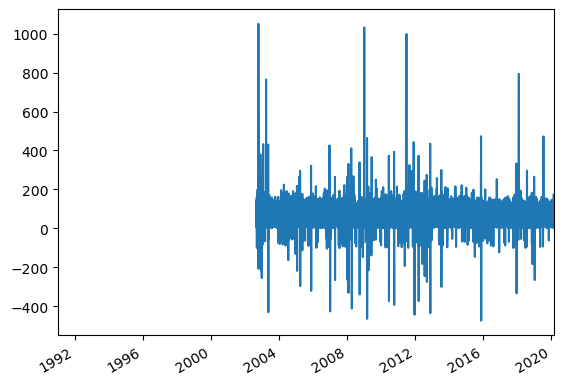

In [71]:
fig, ax = plt.subplots()
ax.plot_date(x=single_test.loc[single_test.index <= test_index]['Datetime'], y=single_test.loc[single_test.index <= test_index]['Amount'], linestyle='solid', marker='None')
fig.autofmt_xdate()
ax.set_xlim([dt.date(1991, 1, 1), dt.date(2020, 3, 1)])
plt.show()

In [66]:
test_index = 5007

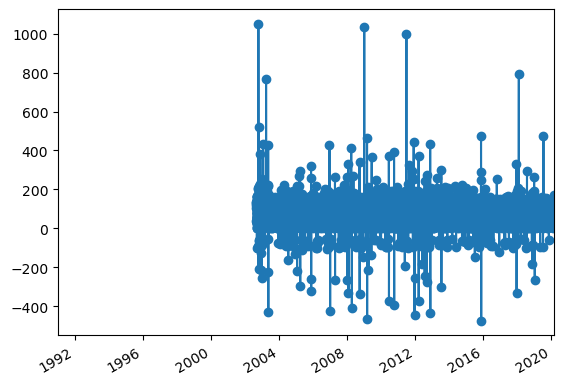

In [67]:
fig, ax = plt.subplots()
ax.plot_date(x=single_test.loc[single_test.index <= test_index]['Datetime'], y=single_test.loc[single_test.index <= test_index]['Amount'], linestyle='solid')
fig.autofmt_xdate()
ax.set_xlim([dt.date(1991, 1, 1), dt.date(2020, 3, 1)])
plt.show()